In [5]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

## previously prepared dataset

In [6]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv',
                      skiprows=[0,1,2,3])
raw_data.columns =['city',
                   'population',
                   'violent_crime',
                   'murder',
                   'rape_def_1',
                   'rape_def_2',
                  'robbery',
                  'aggravated_assault',
                  'property_crime',
                  'burglary',
                  'larceny_theft',
                  'motor_vehicle_theft',
                  'arson']

In [22]:
#set dataframe
df = raw_data[['city', 'population']].copy()

#get population^2 variable
df = df.dropna(axis=0, subset=['population']) #drop nan values
df['population'] = df['population'].str.replace(',', '') #get rid of commas
df['population'] = df['population'].astype(str).astype(int) #from object cast to string then int
df['population_sq'] = df['population'] ** 2 #square column and put in new column

#add other desired variables
df['murder'], df['robbery'] = raw_data['murder'], raw_data['robbery']
df.head()

#prepare murder and robbery to be iterated on
df['murder'] = df['murder'].astype(int)
df['robbery'] = df['robbery'].str.replace(',', '')
df['robbery'] = df['robbery'].astype(int)

#change values to 0 or 1 for multivariable regression
df.loc[df['murder'] > 0, ['murder']] = 1
df.loc[df['robbery'] > 0, ['robbery']] = 1

#add property crime variable
df['property_crime'] = raw_data['property_crime']
df['property_crime'] = df['property_crime'].str.replace(',', '') #get rid of commas
df['property_crime'] = df['property_crime'].astype(int)
df.head()

,city,population,population_sq,murder,robbery,property_crime
0,Adams Village,1861,3463321,0,0,12
1,Addison Town and Village,2577,6640929,0,0,24
2,Akron Village,2846,8099716,0,0,16
3,Albany,97956,9595377936,1,1,4090
4,Albion Village,6388,40806544,0,1,223


## Regression 1

In [20]:
#instantiate and fit model
regr = linear_model.LinearRegression()
Y = df['property_crime'].values.reshape(-1,1)
X = df[['population','population_sq','murder','robbery']]
regr.fit(X,Y)

#inspect results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 3.46570268e-02 -2.11108019e-09  1.51866535e+01 -9.62774363e+01]]

Intercept: 
 [-109.57533562]

R-squared:
0.9961247104988709


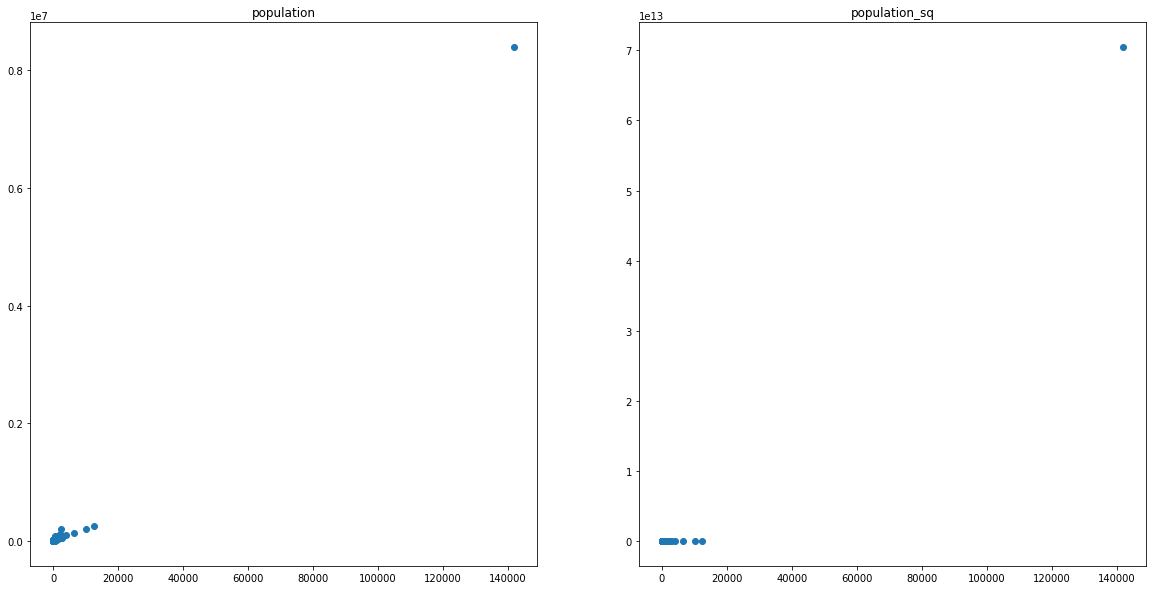

In [30]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.scatter(df['property_crime'], df['population'])
plt.title('population')

plt.subplot(1,2,2)
plt.scatter(df['property_crime'], df['population_sq'])
plt.title('population_sq')

plt.show()

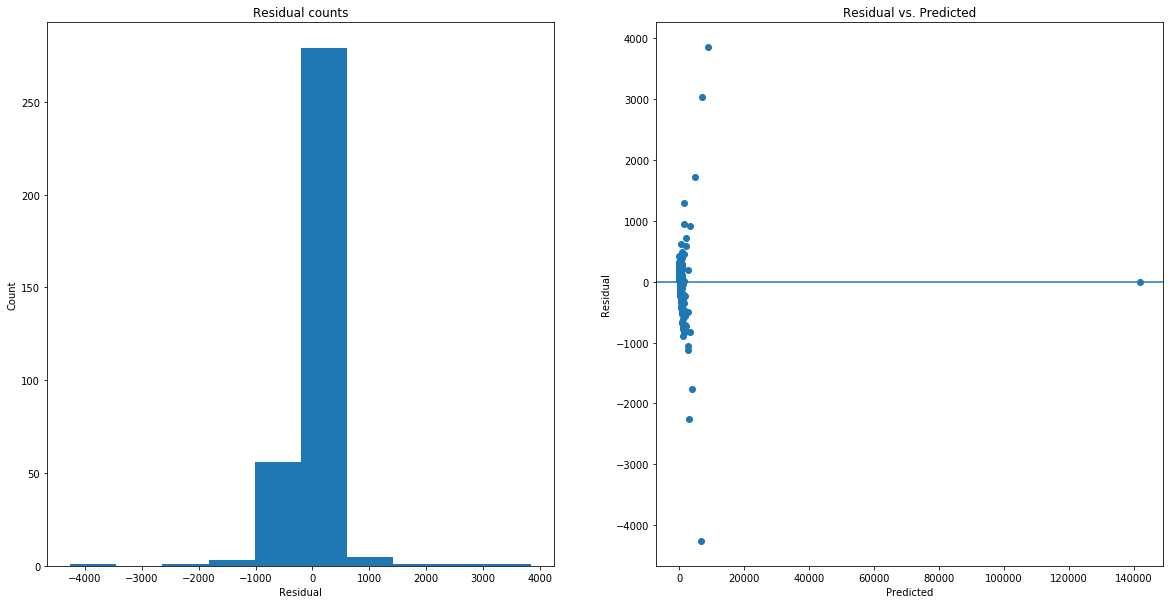

In [31]:
predicted = regr.predict(X).ravel()
actual = df['property_crime']
residual = actual - predicted

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')

plt.show()

In [27]:
correlation_matrix = X.corr()
display(correlation_matrix)

,population,population_sq,murder,robbery
population,1.000,0.998,0.162,0.064
population_sq,0.998,1.000,0.133,0.044
murder,0.162,0.133,1.000,0.313
robbery,0.064,0.044,0.313,1.000


## Regression 2

In [42]:
#take 2, exclude extreme outliers using 3 std dvs
df2 = df
df2 = df2[np.abs(df2.population - df2.population.mean()) <= (3 * df2.population.std())]

In [44]:
#instantiate and fit model
Y2 = df2['property_crime'].values.reshape(-1,1)
X2 = df2[['population','population_sq','murder','robbery']]
regr.fit(X2,Y2)

#inspect results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X2, Y2))


Coefficients: 
 [[1.29510871e-02 1.14920528e-07 1.95038666e+02 9.28205845e+01]]

Intercept: 
 [-16.81586632]

R-squared:
0.8444937611173492


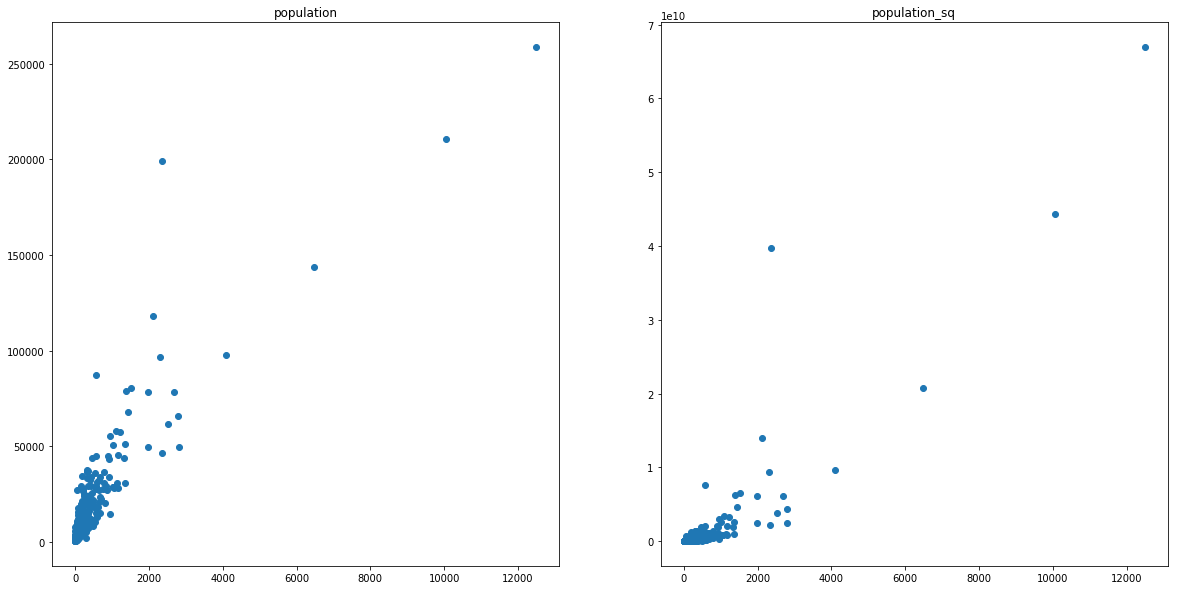

In [41]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.scatter(df2['property_crime'], df2['population'])
plt.title('population')

plt.subplot(1,2,2)
plt.scatter(df2['property_crime'], df2['population_sq'])
plt.title('population_sq')

plt.show()

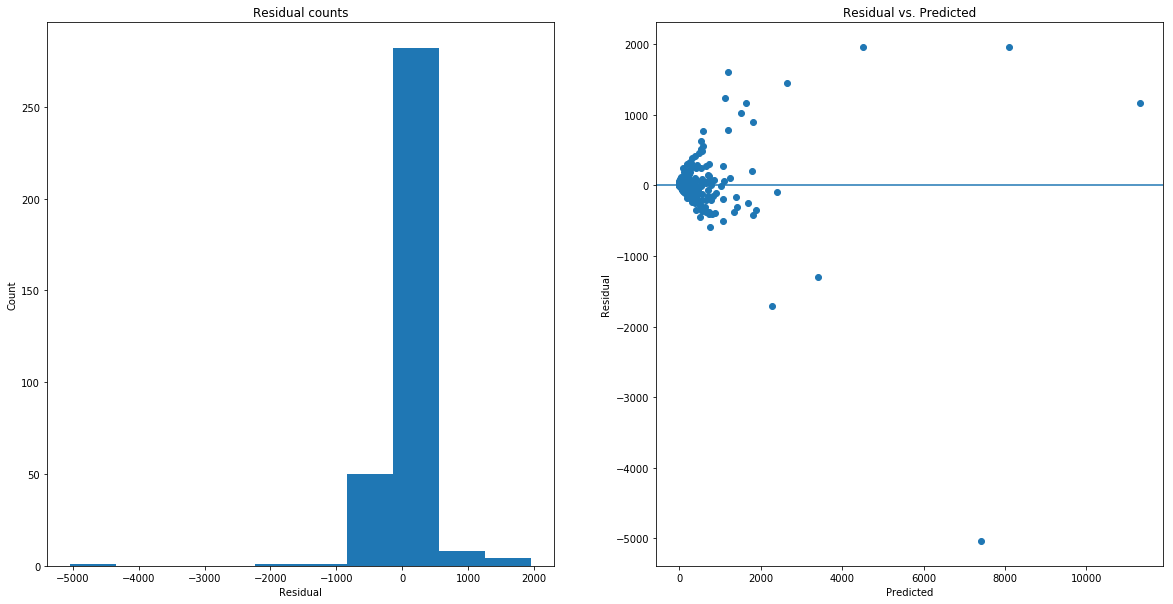

In [45]:
predicted2 = regr.predict(X2).ravel()
actual2 = df2['property_crime']
residual2 = actual2 - predicted2

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.hist(residual2)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.scatter(predicted2, residual2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')

plt.show()

In [48]:
correlation_matrix2 = X2.corr()
display(correlation_matrix2)

,population,population_sq,murder,robbery
population,1.000,0.889,0.503,0.344
population_sq,0.889,1.000,0.345,0.152
murder,0.503,0.345,1.000,0.311
robbery,0.344,0.152,0.311,1.000


## Regression 3

In [51]:
#in both models population and population_sq are highly correlated, eliminate one
df3 = df[['population','murder','robbery','property_crime']].copy()

#instantiate and fit model
Y3 = df3['property_crime'].values.reshape(-1,1)
X3 = df3[['population','murder','robbery']]
regr.fit(X3,Y3)

#inspect results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X3, Y3))


Coefficients: 
 [[1.68728222e-02 6.07383740e+02 1.06994709e+02]]

Intercept: 
 [-32.72226824]

R-squared:
0.99344854357257


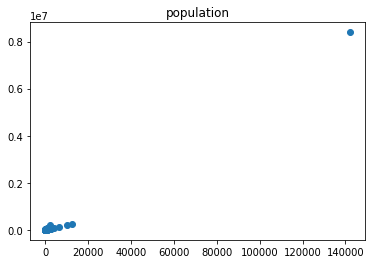

In [55]:
plt.scatter(df3['property_crime'], df3['population'])
plt.title('population')
plt.show()

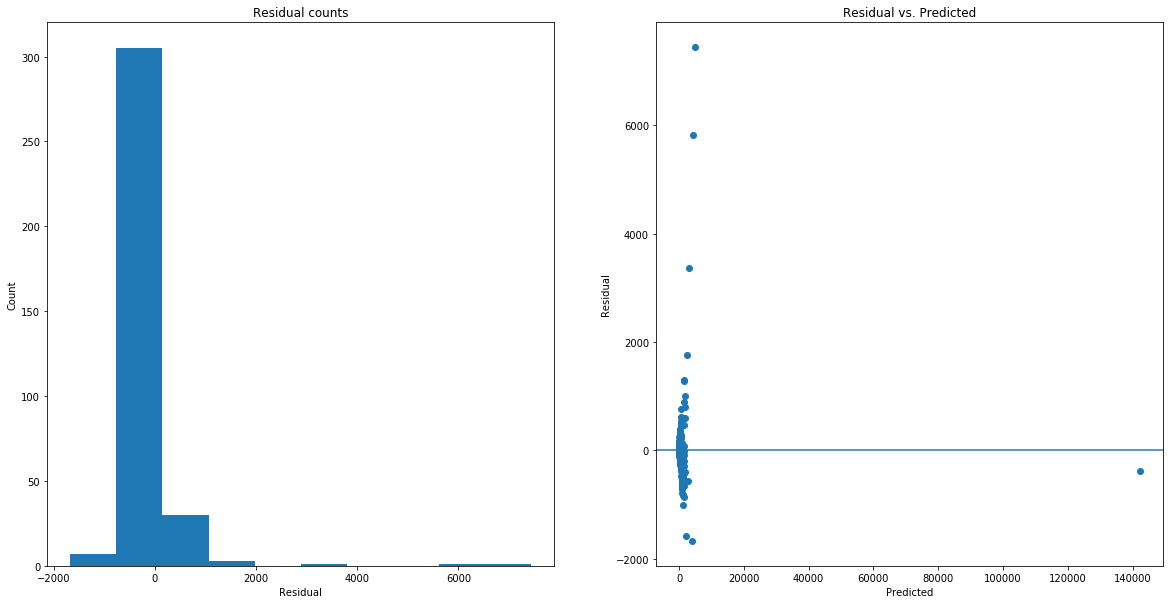

In [56]:
predicted3 = regr.predict(X3).ravel()
actual3 = df3['property_crime']
residual3 = actual3 - predicted3

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.hist(residual3)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.scatter(predicted3, residual3)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')

plt.show()

In [57]:
correlation_matrix3 = X3.corr()
display(correlation_matrix3)

,population,murder,robbery
population,1.000,0.162,0.064
murder,0.162,1.000,0.313
robbery,0.064,0.313,1.000


## Regression 4

In [59]:
#last time eliminated pop_sq, this time keep it
df4 = df[['population_sq','murder','robbery','property_crime']].copy()

#instantiate and fit model
Y4 = df4['property_crime'].values.reshape(-1,1)
X4 = df4[['population_sq','murder','robbery']]
regr.fit(X4,Y4)

#inspect results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X4, Y4))


Coefficients: 
 [[1.99256120e-09 1.18406016e+03 3.00052598e+02]]

Intercept: 
 [40.08610471]

R-squared:
0.9859871204030131


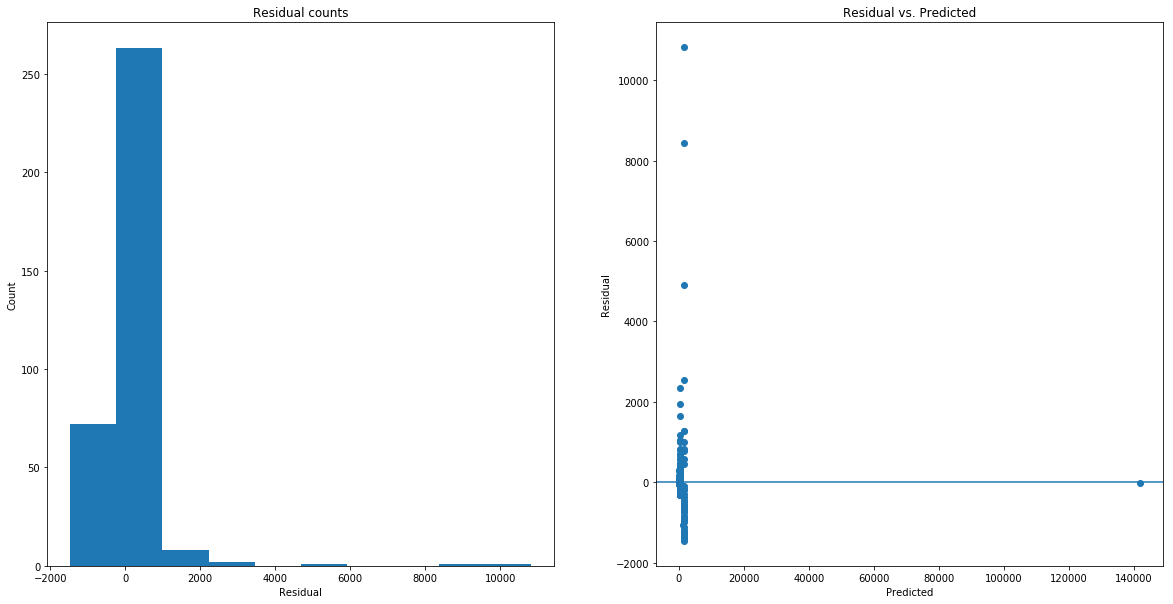

In [60]:
predicted4 = regr.predict(X4).ravel()
actual4 = df4['property_crime']
residual4 = actual4 - predicted4

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.hist(residual4)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.scatter(predicted4, residual4)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')

plt.show()

In [62]:
correlation_matrix = X.corr()
display(correlation_matrix)

correlation_matrix4 = X4.corr()
display(correlation_matrix4)

,population,population_sq,murder,robbery
population,1.000,0.998,0.162,0.064
population_sq,0.998,1.000,0.133,0.044
murder,0.162,0.133,1.000,0.313
robbery,0.064,0.044,0.313,1.000


,population_sq,murder,robbery
population_sq,1.000,0.133,0.044
murder,0.133,1.000,0.313
robbery,0.044,0.313,1.000


This is the best correlation matrix so far as it eliminates highly correlated population & population squared, and has slightly lower correlation between population squared and murder/robbery than in regression 3 (which kept population and eliminated population squared)